# Download a chunk of an ITS_LIVE datacube, invert for average velocities between each satellite observation

requires datacube_tools.py in directory with notebook.  
https://github.com/nasa-jpl/its_live/blob/main/notebooks/datacube_tools.py

In [1]:
import xarray
import numpy as np
import matplotlib.pyplot as plt
import itsinv

## Invert for velocity timeseries

In [16]:
xy = (-3310000, 257700)
solu, res, xsub, mask = itsinv.grid_inversion(xy, half_dist=6000, lt=1e-4, lx=10, sat_filt=["1A"], start_date="2017-10-01", stop_date="2018-10-01", pbar=True, return_data=True)

original xy (-3310000, 257700) 3413 maps to datacube (-3310000, 257700) EPSG:3413
subset and load at  34.65 seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19208/19208 [05:09<00:00, 62.11it/s]


In [17]:
# Convert decimal year to datetime64
s_in_year = (60*60*24*365)
solu_datetime = [None]*len(solu)
for i in range(len(solu)):
    whole_year = int(solu[i])
    frac_year = solu[i] - whole_year
    solu_datetime[i] = np.datetime64(str(whole_year))
    solu_datetime[i] += np.timedelta64(int(frac_year*s_in_year), "s")
    
# Make components into speed
v = np.sqrt(res["vx"]**2 + res["vy"]**2)

## Quck plots to see if reasonable

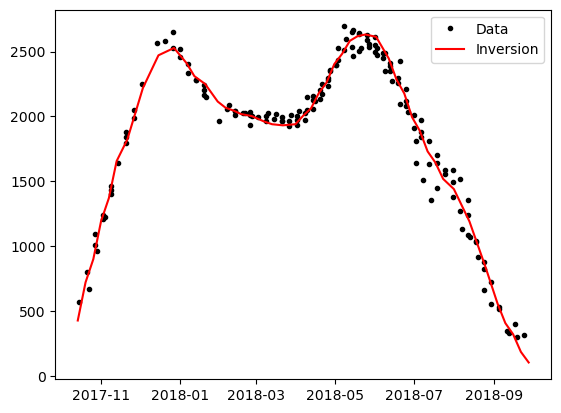

In [21]:
# mid-dates for data
md = xsub.acquisition_date_img1 + ((xsub.acquisition_date_img2 - xsub.acquisition_date_img1)/2)
v_data = np.sqrt(xsub.vx**2 + xsub.vy**2)

plt.plot(md[mask], v_data[mask][:,50,50], "k.", label="Data")
plt.plot(solu_datetime, v[:,50,50], "r-", label="Inversion")
plt.legend()

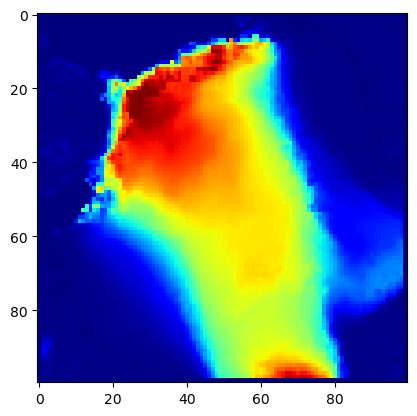

In [22]:
plt.imshow(np.mean(v, axis=0), vmin=0, vmax=2500, cmap="jet")

## Package and save results

In [23]:
xres = xarray.Dataset(
    data_vars = dict(
        speed=(["time", "y", "x"], v),
    ),
    coords = dict(
        x = xsub.x,
        y = xsub.y,
        time = solu_datetime,
    ),
    attrs = dict(
        projection = xsub.projection,
        GDAL_AREA_OR_POINT = xsub.GDAL_AREA_OR_POINT,
    ))

xres.to_netcdf("hubbard_2018.nc")